# Import thre libraries

In [1]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
#@title Load the imports

# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


# Upload the data

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

# Normalize data

In [3]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12330,-1.0,1.3,-0.3,1.0,0.5,0.4,0.6,0.6,-0.2
263,1.5,-1.2,-1.1,-0.3,-0.4,-0.8,-0.8,0.1,-0.5
3005,0.9,-0.9,-1.0,1.7,0.8,1.5,0.8,1.7,0.9
11146,-0.7,1.4,-2.0,2.2,1.5,1.5,1.5,0.3,-0.1
13664,-1.2,0.9,-0.0,0.2,-0.1,0.3,0.0,0.8,0.2


In [4]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

# Label data 
# Houses with value higher than 75 percentile are high value 1
# while others 0

In [5]:
threshold = 265000
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)


12330   0.0
263     0.0
3005    1.0
11146   0.0
13664   0.0
         ..
1399    0.0
15676   0.0
4861    0.0
13838   1.0
15347   1.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

# features in feature column

In [10]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[ 0.60452163,  0.95201194],
       [ 0.12652102, -0.30214697],
       [ 1.6892335 ,  1.6951492 ],
       ...,
       [-0.87795633, -0.9962005 ],
       [-0.43029913, -0.8806014 ],
       [ 2.684697  ,  0.9708197 ]], dtype=float32)>

# Create train model function



In [6]:
#@title Define the functions that create and train a model.
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


# Define plotting function

In [8]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


# invoke traninig, plotting functions

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 1ms/step - loss: 0.9389 - accuracy: 0.2241
Epoch 2/20
170/170 [==============================] - 0s 1ms/step - loss: 0.8407 - accuracy: 0.2457
Epoch 3/20
170/170 [==============================] - 0s 1ms/step - loss: 0.7537 - accuracy: 0.2889
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.6796 - accuracy: 0.4013
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 0.6162 - accuracy: 0.5963
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5660 - accuracy: 0.7076
Epoch 7/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5253 - accuracy: 0.7646
Epoch 8/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4932 - accuracy: 0.8039
Epoch 9/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4676 - accurac

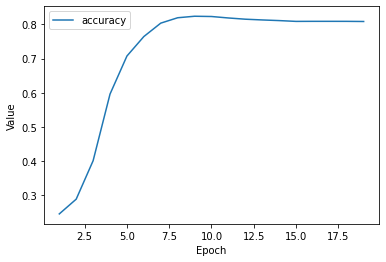

In [11]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate the model against test set


In [12]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 1ms/step - loss: 0.4067 - accuracy: 0.8003


[0.40674683451652527, 0.8003333210945129]

# Adding Accuracy metrics

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 1ms/step - loss: 0.9350 - accuracy: 0.1788 - precision: 0.1418 - recall: 0.4528
Epoch 2/20
170/170 [==============================] - 0s 1ms/step - loss: 0.8229 - accuracy: 0.1790 - precision: 0.1367 - recall: 0.4300
Epoch 3/20
170/170 [==============================] - 0s 1ms/step - loss: 0.7318 - accuracy: 0.1986 - precision: 0.1325 - recall: 0.3982
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.6582 - accuracy: 0.2919 - precision: 0.1251 - recall: 0.3061
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5982 - accuracy: 0.6109 - precision: 0.1901 - recall: 0.1709
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5505 - accuracy: 0.7392 - precision: 0.4451 - recall: 0.1785
Epoch 7/20
170/170 [==============================] - 0s 1ms/step - 

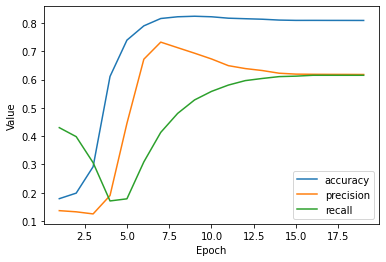

In [16]:
#@title Double-click to view the solution for Task 3.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)


# The new graphs suggest that precision and recall are 
# somewhat in conflict. That is, improvements to one of
# those metrics may hurt the other metric.